https://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html


http://www.scipy-lectures.org/advanced/image_processing/#feature-extraction

In [237]:
from scipy import ndimage
from scipy import misc

import numpy as np

In [238]:
import matplotlib.pyplot as plt
%matplotlib inline

    $ convert -density 200 pdfs/US4893406.pdf -resize 1200x images/test.png

In [240]:
filename = "images/test-0.png"
I = misc.imread(filename, mode='L') # ‘L’ (8-bit pixels, black and white)

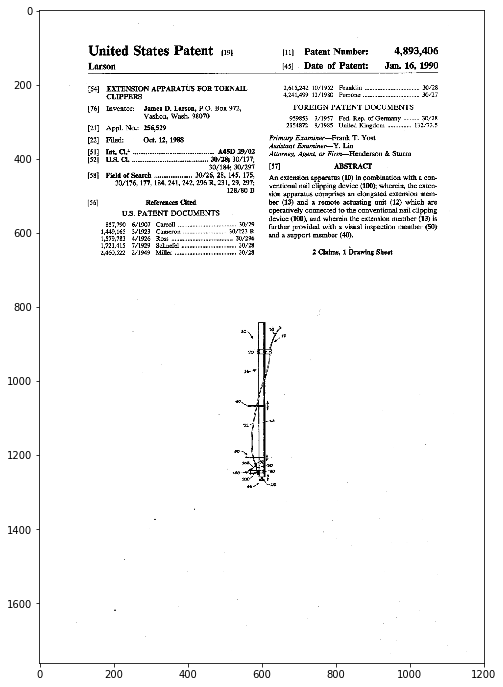

In [241]:
plt.figure( figsize=(12, 12) )
plt.imshow( I, cmap="gray" );

In [260]:
size = 11
M = np.zeros( (size, size) )
M[ int(size/2), int(size/2) ] = 1
M = ndimage.binary_dilation(M, iterations=int(size/2)).astype(M.dtype)

In [261]:
# Convert to binary
# and dilation

B =  I<100 
struct = M
B = ndimage.binary_dilation(B, structure=struct) 

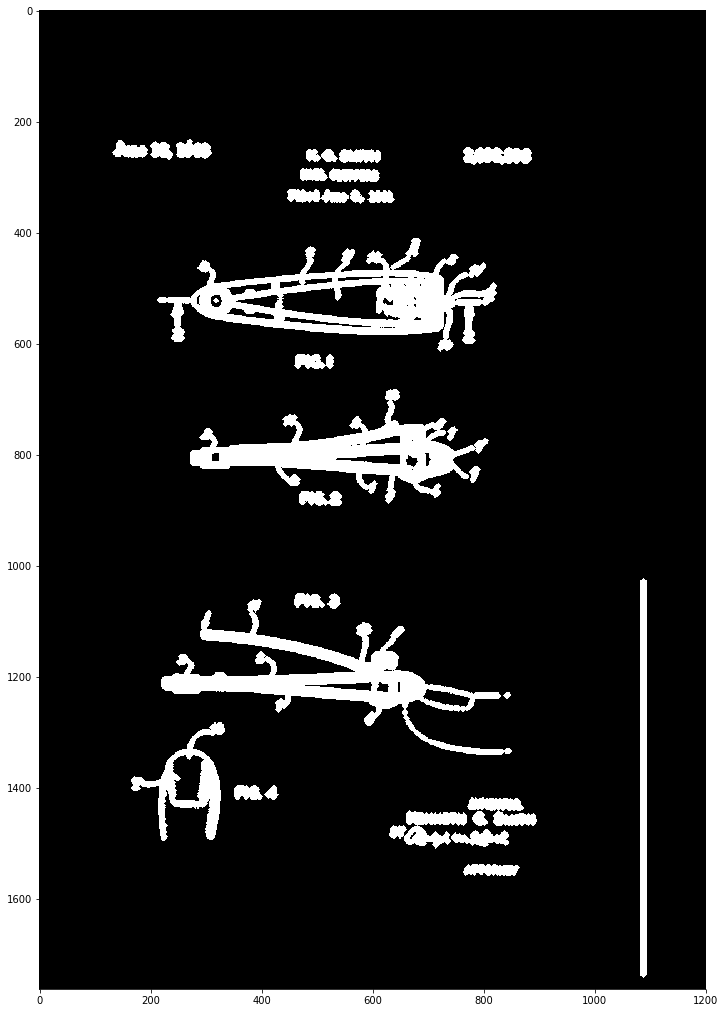

In [262]:
plt.figure( figsize=(18, 18) )
plt.imshow( B, cmap="gray" );

In [263]:
# segmentation
B_label, nb_labels = ndimage.label( B )

print( nb_labels )

37


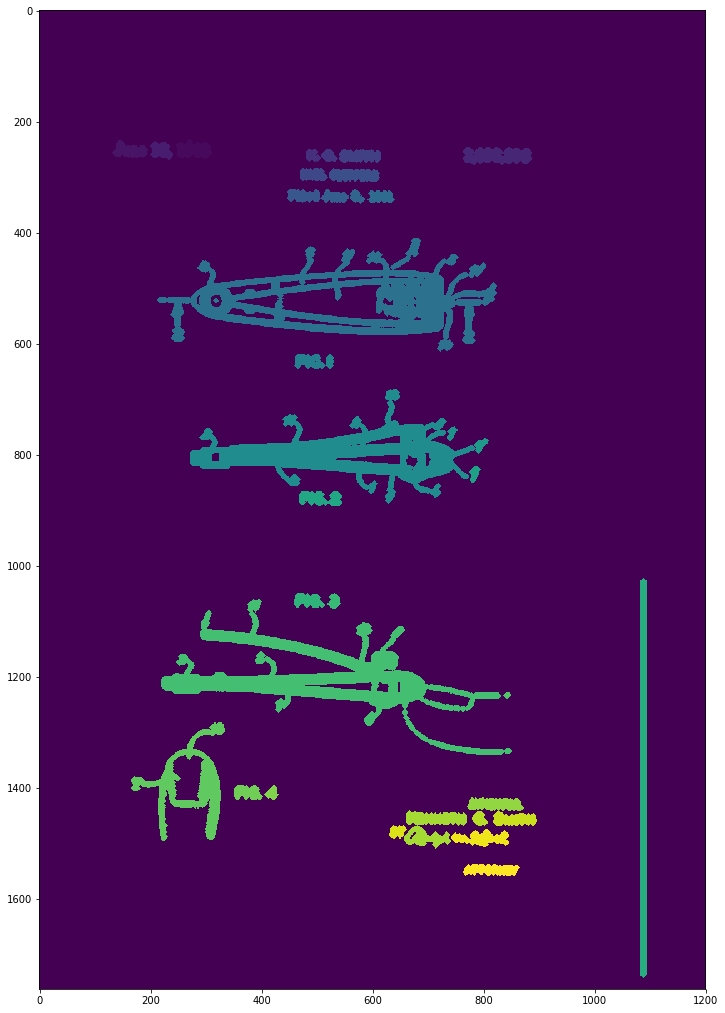

In [264]:
plt.figure( figsize=(18, 18) )
plt.imshow( B_label  );

In [265]:
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.measurements.sum.html#scipy.ndimage.measurements.sum
sizes = ndimage.sum( B , B_label, range(nb_labels + 1))

In [266]:
max( sizes )

42690.0

In [267]:
mask_size = sizes < 10000

remove_pixel = mask_size[ B_label ]

remove_pixel.shape

(1763, 1200)

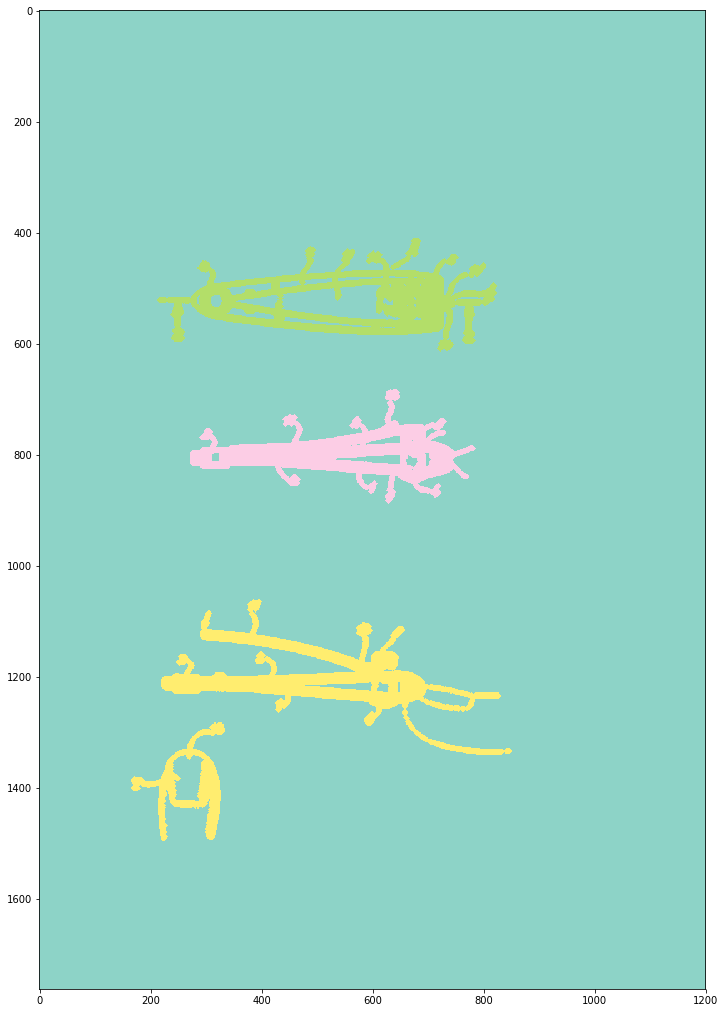

In [268]:
B_label[remove_pixel] = 0

plt.figure( figsize=(18, 18) )
plt.imshow( B_label, cmap='Set3'  );

In [269]:
labels = np.unique(B_label)
B_label = np.searchsorted(labels, B_label)

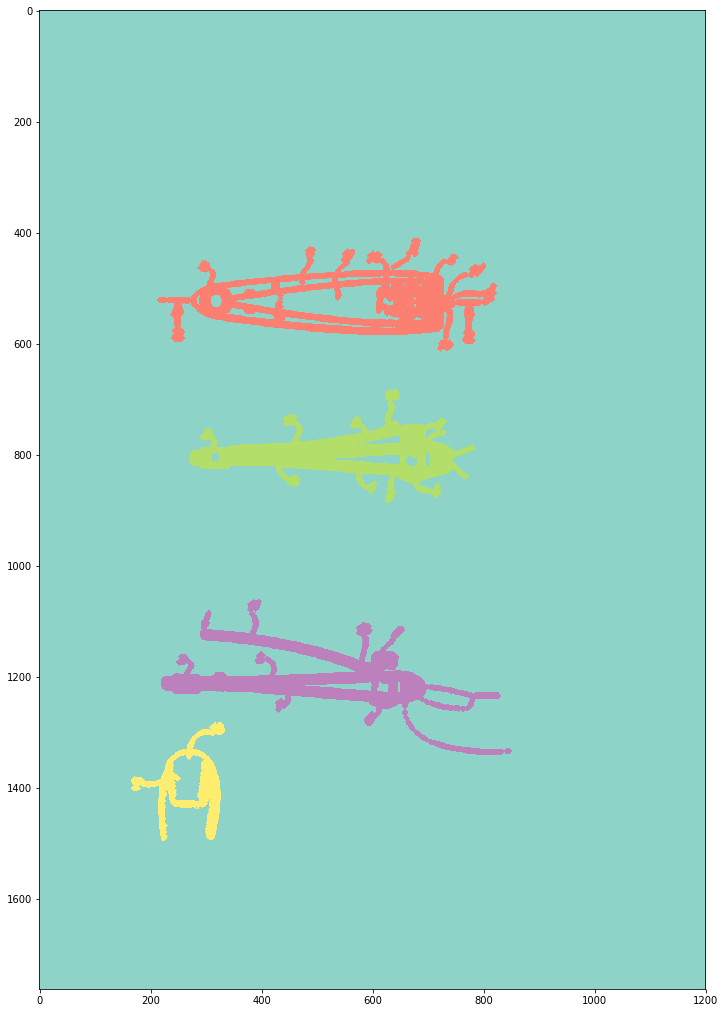

In [270]:
plt.figure( figsize=(18, 18) )
plt.imshow( B_label, cmap='Set3'  );

In [271]:
bounting_box = ndimage.measurements.find_objects(B_label)

In [277]:
k = 2
Icrop = I[ bounting_box[ k ] ]
mask =  B_label[ bounting_box[ k ] ] != k+1
Icrop[ mask ] = 255

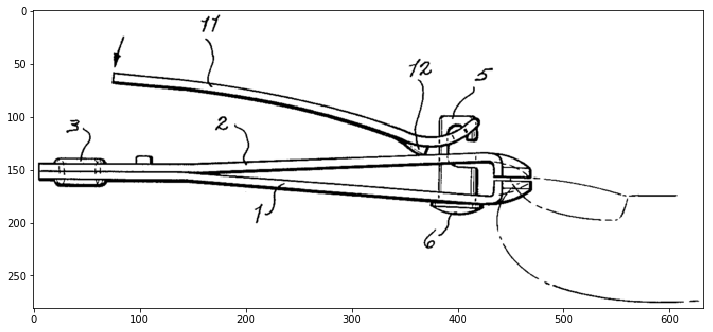

In [278]:
plt.figure( figsize=(12, 12) )
plt.imshow( Icrop , cmap='gray'  );

1. calculte and filter on ratio
2. extract first image and save ... 

3. faire la segmentation du premier coup, en fournisant la matrice de connectivité

## Compact version 

In [86]:
from scipy import ndimage, misc
import numpy as np

import urllib.request

import subprocess, os

In [225]:
def extractimages( filename ):
    # read
    I = misc.imread( filename, mode='L') # ‘L’ (8-bit pixels, black and white)

    # params
    BINARY_THRESHOLD = 120 # gray value used for binary conversion
    MAX_SIZE = 10000 # maximal size in number of pixel allowed for isolated image
    DILATATION_SIZE = 13 # diameter in pixels used for the Dilation operation

    # Convert to binary 
    B =  I < BINARY_THRESHOLD 

    # Matrice de connexion
    size = DILATATION_SIZE
    M = np.zeros( (size, size) )
    M[ int(size/2), int(size/2) ] = 1
    M = ndimage.binary_dilation(M, iterations=int(size/2)).astype(M.dtype)

    # Dilation
    B = ndimage.binary_dilation(B, structure=M) 

    # Segmentation
    B_label, nb_labels = ndimage.label( B )

    # Calculs les tailles (nombres de pixels)
    sizes = ndimage.sum( B , B_label, range(nb_labels + 1))

    # Remove pixel in too small cluster
    mask_size = sizes < MAX_SIZE
    remove_pixel = mask_size[ B_label ]
    B_label[remove_pixel] = 0

    # Rename labels
    labels = np.unique(B_label)
    B_label = np.searchsorted(labels, B_label)

    # Compute bounting box
    bounting_box = ndimage.measurements.find_objects(B_label)
    
    images_crop = []
    # crop, erase unwanted pixels and save
    for k, bbox in enumerate( bounting_box ):
        Icrop = I[ bbox ]
        mask =  B_label[ bbox ] != k+1
        Icrop[ mask ] = 255
        images_crop.append( Icrop )
        
    return images_crop

In [232]:
#patent_number = 'US3937234'
patent_number = 'US3090581' # Flying car
#patent_number = 'US6130666'
patent_number = 'US5134752' # vaccum cleaner

patent_number = 'US9045226' 

patent_number = 'US391895' # tandem

patent_number = 'US3746118'

In [233]:
PATH = 'images/'

# download the patent pdf file
pdfname = '%s.pdf' % patent_number

if not os.path.isfile(PATH+pdfname) :

    url = 'http://patentimages.storage.googleapis.com/pdfs/%s.pdf' % patent_number
    #url = 'http://www.pat2pdf.org/pat2pdf/foo.pl?number=%s' % patent_number
    #url = 'http://www.pat2pdf.org/patents/pat%s.pdf' % patent_number.strip('US')
    
    try:
        local_filename, headers = urllib.request.urlretrieve(url, PATH+pdfname)
        print( 'save %s'%local_filename )

    except urllib.error.HTTPError as err:  
        print('http error', err.code, patent_number)
        
else:
    local_filename = PATH+pdfname
    print('already saved : %s'%local_filename)

save images/US3746118.pdf


In [234]:
# Convert PDF to png using ImageMagick
page_filename = local_filename.strip('.pdf') + '-page.png'
cmd  = "convert -density 250  %s -resize 1200x  %s" % (local_filename, page_filename)

return_code = subprocess.call(cmd, shell=True)  

In [235]:
# Retrouve les images 
allfiles = os.listdir(PATH)
patent_pages = [ PATH+p for p in allfiles if p.startswith( patent_number+'-page' ) ]
print( len(patent_pages ) )

6


In [236]:
all_images = []
for filename in patent_pages:

    images = extractimages( filename )
    
    page = filename.split('-')[-1].strip('.png')
    
    for k, I in enumerate( images ):
        all_images.append( I )
        image_filename =  'images/%s-crop%s-%s.png'%( patent_number, page, str(k).zfill(3) )
        misc.imsave(image_filename, I)  
        
print( len(all_images) )

23


# work in progress

In [165]:
I = all_images[12]
I =  I < 20
plt.figure( figsize=(12, 12) )
plt.imshow( I , cmap='gray'  );

IndexError: list index out of range

In [143]:
Ic = ndimage.binary_dilation(I, iterations=2)

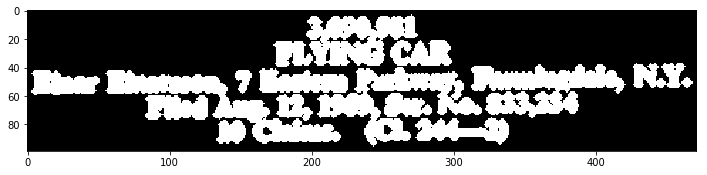

In [144]:
plt.figure( figsize=(12, 12) )
plt.imshow( Ic , cmap='gray'  );

In [113]:
d = I.sum()/(I.shape[0]*I.shape[1])/255
print( d )

0.844254211315


In [114]:
all_d = [ I.sum()/(I.shape[0]*I.shape[1])/255 for I in all_images  ]

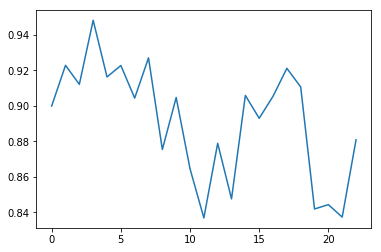

In [115]:
plt.plot( all_d )

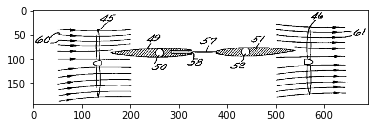

In [149]:
for i in range(3):
    plt.subplot()
    plt.imshow( all_images[i] , cmap='gray'  );


# brouillon

In [ ]:
B = ndimage.binary_closing(B)
B = ndimage.binary_opening(B)